Perform [box method](https://doi.org/10.1029/2007JF000927) by terminating [curvilinear boxes](https://doi.org/10.3189/2014JoG13J061) with terminus traces and write resulting geometry to disk

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point
from shapely.ops import split

# Flag to enable descriptive plots of box method
PLOT = False

# Read terminus boxes and traces
boxes = gpd.read_file("../data/terminus/terminus_boxes.geojson")
traces = gpd.read_file("../data/terminus/terminus_traces_1985_2023.geojson")

# To store trace-terminated boxes before combined
boxes_gdf = []

# Perform box method
for glacier, traces_glacier in traces.groupby(by="glacier"):
    # Collect curvilinear box for current glacier
    box_glacier = boxes.loc[boxes.glacier == glacier].reset_index()

    # Remove traces with quality flag of '1' and sort by date
    traces_glacier = traces_glacier.loc[traces_glacier.quality != "1"]
    traces_glacier = traces_glacier.sort_values(by="date", ascending=False)

    for _, trace in traces_glacier.iterrows():
        # Attempt to split box by terminus trace
        difference = split(box_glacier.geometry.item(), trace.geometry.geoms[0])

        # Relocate distances are null if box was split successfully
        start_relocate_distance = 0
        end_relocate_distance = 0

        # If split was unsuccessful then extend trace to fully intersect box
        if len(difference.geoms) == 1:
            # Alias necessary geometry
            box_poly = box_glacier.geometry.item().geoms[0]
            box_edge = box_poly.exterior
            trace_line = trace.geometry.geoms[0]
            trace_start_coords = trace_line.coords[0]
            trace_end_coords = trace_line.coords[-1]
            trace_start_point = Point(trace_start_coords)
            trace_end_point = Point(trace_end_coords)

            # Copy of trace where relocated start/end coords will be inserted
            trace_line_extended = list(trace_line.coords)

            # Trace start point falls within box, so we need to extend to edge
            if box_poly.contains(trace_start_point):
                start_interp = box_edge.interpolate(box_edge.project(trace_start_point))
                shifted = box_edge.interpolate(box_edge.project(start_interp) - 10)
                vector = np.array(start_interp.coords[0]) - np.array(shifted.coords[0])
                start_interp_extended = (vector[1], -vector[0]) / np.linalg.norm(vector)
                start_interp_extended = (
                    start_interp.x - start_interp_extended[0] * 50,
                    start_interp.y - start_interp_extended[1] * 50,
                )
                trace_line_extended[0] = start_interp_extended
                start_relocate_distance = start_interp.distance(trace_start_point)

            # Trace start point falls within box, so we need to extend to edge
            if box_poly.contains(trace_end_point):
                end_interp = box_edge.interpolate(box_edge.project(trace_end_point))
                shifted = box_edge.interpolate(box_edge.project(end_interp) + 50)
                vector = np.array(end_interp.coords[0]) - np.array(shifted.coords[0])
                end_interp_extended = (vector[1], -vector[0]) / np.linalg.norm(vector)
                end_interp_extended = (
                    end_interp.x + end_interp_extended[0] * 50,
                    end_interp.y + end_interp_extended[1] * 50,
                )
                trace_line_extended[-1] = end_interp_extended
                end_relocate_distance = end_interp.distance(trace_end_point)

            # Reconstructs trace line with new start and/or end coords
            trace_line_extended = LineString(trace_line_extended)

            # Splits box by interpolated trace
            difference = split(box_glacier.geometry[0], trace_line_extended)

            # Optional plot to display original and modified trace, plus terminated box
            if PLOT:
                box_glacier.geometry.plot(color="grey", alpha=0.5, edgecolor="black")
                plt.fill(*difference.geoms[1].exterior.xy, linewidth=1, c="red", alpha=0.2)
                plt.plot(*trace_line_extended.xy, linewidth=1, c="blue")
                plt.plot(*trace_line.xy, linestyle="-", linewidth=1, c="orange")
                plt.plot(*trace_start_coords, marker="o", markersize=2, c="green")
                plt.plot(*trace_end_coords, marker="o", markersize=2, c="red")
                plt.show()

        # Assign attributes from trace to trace-terminated box
        box_gdf = trace.drop(labels="geometry")
        box_gdf["geometry"] = difference.geoms[1]
        box_gdf["area"] = difference.geoms[1].area
        box_gdf["area_width_averaged"] = difference.geoms[1].area / box_glacier.width[0]
        box_gdf["start_relocate_distance"] = start_relocate_distance
        box_gdf["end_relocate_distance"] = end_relocate_distance
        box_gdf = gpd.GeoDataFrame(box_gdf).transpose()
        box_gdf = box_gdf.set_geometry("geometry").set_crs(3413)
        boxes_gdf.append(box_gdf)

# Concat trace-terminated boxes into one GeoDataFrame, sort, and save geometry to disk
boxes_gdf = pd.concat(boxes_gdf, ignore_index=True)
boxes_gdf = boxes_gdf.sort_values(by=["glacier", "date"])
boxes_gdf.to_file("../data/terminus/terminus_boxes_1985_2023.geojson", driver="GeoJSON")
boxes_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1020 entries, 729 to 730
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   date                     1020 non-null   object  
 1   image_id                 959 non-null    object  
 2   satellite                959 non-null    object  
 3   quality                  1020 non-null   object  
 4   glacier                  1020 non-null   object  
 5   glacier_code             1020 non-null   object  
 6   source                   1020 non-null   object  
 7   geometry                 1020 non-null   geometry
 8   area                     1020 non-null   object  
 9   area_width_averaged      1020 non-null   object  
 10  start_relocate_distance  1020 non-null   object  
 11  end_relocate_distance    1020 non-null   object  
dtypes: geometry(1), object(11)
memory usage: 103.6+ KB


Convert to xarray.Dataset and calculate changes in terminus position relative to first observation

In [2]:
# Metadata for final Dataset
GLOBAL_ATTRS = {
    "author": "King, O. G.",
    "projection": "3413",
    "title": "Terminus traces for Daugaard-Jensen and Unnamed Uunartit Islands glaciers, Greenland, 1985-2024",
    "version": "2024-06-27",
}
VAR_ATTRS = {
    "glacier": {
        "description": "Glacier name, as taken from the Mouginot and others (2019) Greenland basins dataset",
    },
    "time": {
        "description": "Datetime of image used for terminus trace",
    },
    "image_id": {
        "description": "ID of satellite image used for terminus trace",
    },
    "satellite": {
        "description": "Name of imaging satellite",
    },
    "quality": {
        "description": "Quality flag of terminus trace",
        "units": "0=no issues/not supplied; 1=estimated, uncertain, or affected by cloud cover",
    },
    "source": {
        "description": "Source of terminus trace",
        "citation": [
            "Black=Black & Joughin (2022) https://doi.org/10.5067/DGBOSSIULSTD",
            "Brough=Brough and others (2023) https://doi.org/10.5281/zenodo.6904218",
            "Joughin=Joughin and others (2021) https://doi.org/10.5067/ESFWE11AVFKW",
            "King=King (2024) This study",
            "TermPicks_<AUTHOR>=Goliber and others (2021) https://doi.org/10.5281/zenodo.6557981",
        ],
    },
    "geometry_wkt": {
        "description": "Geometry of trace-terminated box",
        "type": "Well Known Text (WKT)",
    },
    "area": {
        "description": "Box area",
        "units": "metres squared [m2]",
    },
    "area_width_averaged": {
        "description": "Box area normalised by glacier width",
        "units": "metres squared [m2]",
    },
    "start_relocate_distance": {
        "description": "Distance from original start node to interpolated start node on box edge",
        "units": "metres",
    },
    "end_relocate_distance": {
        "description": "Distance from original end node to interpolated end node on box edge",
        "units": "metres",
    },
    "area_width_averaged_change": {
        "description": "Change in width-averaged box area relative to the earliest observation",
        "units": "metres squared [m2]",
    },
}

# Convert geometry to WKT (because xarray disallows arbitrary Python objects when writing NetCDF)
boxes_gdf["geometry_wkt"] = [geom.wkt for geom in boxes_gdf.geometry.values]

# Convert GeoDataFrame to xarray.Dataset
terminus_ds = boxes_gdf.set_index(["glacier", "date"]).to_xarray()

# Assign types to each dim/coord/var
terminus_ds = terminus_ds.rename(date="time")
terminus_ds = terminus_ds.drop_vars(["geometry", "glacier_code"])
terminus_ds["time"] = pd.to_datetime(terminus_ds.time)
terminus_ds["area"] = terminus_ds.area.astype(float)
terminus_ds["area_width_averaged"] = terminus_ds.area_width_averaged.astype(float)
terminus_ds["end_relocate_distance"] = terminus_ds.end_relocate_distance.astype(float)
terminus_ds["start_relocate_distance"] = terminus_ds.start_relocate_distance.astype(float)
terminus_ds["geometry_wkt"] = terminus_ds.geometry_wkt.astype(str)
terminus_ds["glacier"] = terminus_ds.glacier.astype(str)
terminus_ds["image_id"] = terminus_ds.image_id.astype(str)
terminus_ds["quality"] = terminus_ds.quality.astype(str)
terminus_ds["satellite"] = terminus_ds.satellite.astype(str)
terminus_ds["source"] = terminus_ds.source.astype(str)

# Remove traces where either relocation distance exceeds 100 metres
mask = (terminus_ds.start_relocate_distance < 100) & (terminus_ds.end_relocate_distance < 100)
terminus_ds = terminus_ds.where(mask, drop=True)

# Calculate change in terminus position relative to first observation
terminus_area = terminus_ds.area_width_averaged.groupby("glacier")
terminus_baseline = terminus_ds.area_width_averaged.groupby("glacier").first().dropna("time").isel(time=0)
terminus_ds["area_width_averaged_change"] = terminus_area - terminus_baseline

# Assign metadata
terminus_ds = terminus_ds.assign_attrs(GLOBAL_ATTRS)
for key, val in VAR_ATTRS.items():
    terminus_ds[key] = terminus_ds[key].assign_attrs(val)

# Write final Dataset to disk
terminus_ds.to_netcdf("../data/terminus/terminus_1985_2023.nc")
terminus_ds

<xarray.Dataset> Size: 144kB
Dimensions:                     (glacier: 2, time: 854)
Coordinates:
  * glacier                     (glacier) <U24 192B 'DAUGAARD-JENSEN' 'UNNAME...
  * time                        (time) datetime64[ns] 7kB 1985-06-11 ... 2023...
Data variables:
    image_id                    (glacier, time) object 14kB 'LT05_L1TP_232009...
    satellite                   (glacier, time) object 14kB 'LANDSAT_5' ... nan
    quality                     (glacier, time) object 14kB '0' nan ... nan nan
    source                      (glacier, time) object 14kB 'TermPicks_Wood' ...
    area                        (glacier, time) float64 14kB 2.766e+07 ... nan
    area_width_averaged         (glacier, time) float64 14kB 5.533e+03 ... nan
    start_relocate_distance     (glacier, time) float64 14kB 0.0 nan ... nan nan
    end_relocate_distance       (glacier, time) float64 14kB 0.0 nan ... nan nan
    geometry_wkt                (glacier, time) object 14kB 'POLYGON ((560728...
    area_width_averaged_change  (glacier, time) float64 14kB 427.6 nan ... nan
Attributes:
    author:      King, O. G.
    projection:  3413
    title:       Terminus traces for Daugaard-Jensen and Unnamed Uunartit Isl...
    version:     2024-06-27

Quick visualisation of terminus change data at Uunartit Islands glacier

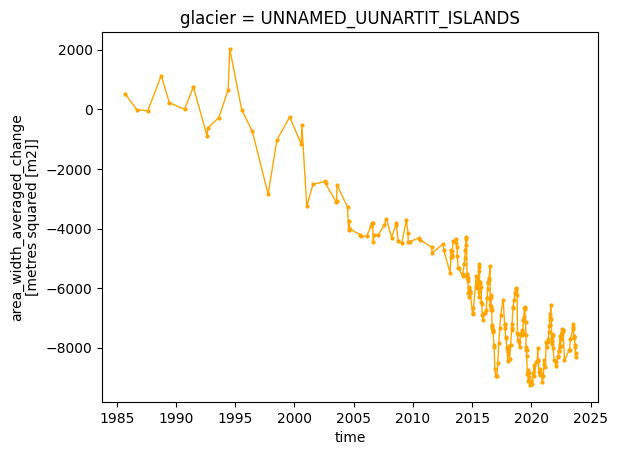

In [3]:
terminus_ds.area_width_averaged_change.sel(glacier="UNNAMED_UUNARTIT_ISLANDS").dropna("time").plot(
    c="orange", marker="o", markersize=2, linewidth=1
)

Linear regression of terminus change against time

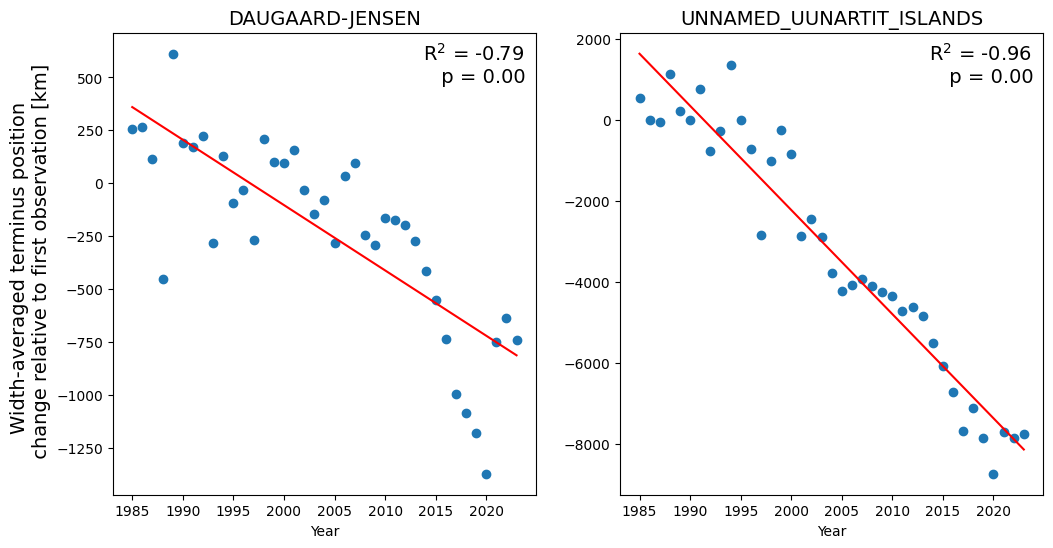

In [4]:
import matplotlib.pyplot as plt
import scipy
import xarray as xr
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

# Set up axes
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(nrows=1, ncols=2, width_ratios=(1, 1))
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
axs = [ax0, ax1]

# Load terminus change data
terminus_ds = xr.open_dataset("../data/terminus/terminus_1985_2023.nc")

for i, (glacier, ds) in enumerate(terminus_ds.groupby("glacier", squeeze=False)):
    # Resample terminus change to annual means and extract years
    terminus_change = ds.area_width_averaged_change.squeeze().resample(time="1YS").mean()
    years = terminus_change.time.dt.year

    # Regress terminus change against year
    res = scipy.stats.linregress(years, terminus_change)

    # Plot data and trendline
    axs[i].plot(years, terminus_change, "o")
    axs[i].plot(years, res.intercept + res.slope * years, "r", label="fitted line")

    # Add R2 and p values to plot
    axs[i].add_artist(
        AnchoredText(
            f"R$^{{2}}$ = {res.rvalue:.2f} \n p = {res.pvalue:.2f}",
            loc="upper right",
            borderpad=0.1,
            prop=dict(fontsize=14, horizontalalignment="right"),
            frameon=False,
        )
    )

    # Label plots
    axs[i].set_title(glacier, fontsize=14)
    axs[i].set_xlabel("Year")

axs[0].set_ylabel("Width-averaged terminus position \n change relative to first observation [km]", size=14)

plt.show()

Width-averaged terminus position change relative to initial observation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from matplotlib.dates import DateFormatter, YearLocator
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

# Global plot settings
plt.rcParams["figure.dpi"] = 1000
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

# Colours and label for each series
PLOT_SETTINGS = {
    "DAUGAARD-JENSEN": {
        "colour": [(0.122, 0.467, 0.706, 1.0), (0.122, 0.467, 0.706, 0.25)],
        "label": "Daugaard-Jensen",
    },
    "UNNAMED_UUNARTIT_ISLANDS": {
        "colour": [(1.0, 0.498, 0.055, 1.0), (1.0, 0.498, 0.055, 0.25)],
        "label": "Uunartit Islands",
    },
}

# Set up axis
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0, 0])

# Load terminus change data
terminus_ds = xr.open_dataset("../data/terminus/terminus_1985_2023.nc")

# Group terminus data by glacier
for glacier, terminus_ds_glacier in terminus_ds.groupby("glacier", squeeze=False):
    # Convert terminus change data to km
    terminus_change = terminus_ds_glacier.area_width_averaged_change.squeeze().dropna("time") / 1000
    ax.plot(
        terminus_change.time,
        terminus_change,
        label=PLOT_SETTINGS[glacier]["label"],
        marker="o",
        linewidth=2.5,
        markersize=3,
        markeredgecolor=PLOT_SETTINGS[glacier]["colour"][0],
        markerfacecolor=PLOT_SETTINGS[glacier]["colour"][0],
        color=PLOT_SETTINGS[glacier]["colour"][1],
    )

# Set y-axis range and add label
ax.set_ylim(bottom=-10, top=3)
ax.set_ylabel("Width-averaged terminus position \n change relative to first observation [km]", labelpad=20)

# Set x-axis range
ax.set_xlim(pd.to_datetime("1985-01-01"), pd.to_datetime("2024-01-01"))

# Format x-axis ticks: text format, frequency, rotation
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.xaxis.set_major_locator(YearLocator(5))
ax.xaxis.set_minor_locator(YearLocator(1))
ax.tick_params(axis="x", rotation=70)

# Remove margin gap
ax.margins(x=0)

# Draw horizontal line at y=0
ax.axhline(y=0, c="black", alpha=0.7, linewidth=0.7, zorder=1, linestyle=(0, (6, 8)))

# Draw grid
ax.grid(True, which="both", axis="both", c="gray", linestyle=":", linewidth=0.5, alpha=0.8, zorder=0)

# Draw axes label
ax.add_artist(AnchoredText("(x)", loc="upper left", borderpad=0.1, prop=dict(weight="semibold"), frameon=False))

# Draw legend
ax.legend(frameon=False, loc="lower left", fontsize=16, markerscale=2, scatterpoints=1)

# # Add text describing direction of terminus change values
# ax.text(0.98, 0.95, "Advance ↑", alpha=0.8, size=18, ha="right", transform=ax.transAxes)
# ax.text(0.98, 0.88, "Retreat ↓", alpha=0.8, size=18, ha="right", transform=ax.transAxes)

plt.tight_layout()
plt.savefig("../img/ts_terminus.png", dpi=fig.dpi, bbox_inches="tight")
plt.show()

Maps of terminus traces

In [ ]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.plot
import rasterio.windows
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.dates import DateFormatter, YearLocator, date2num
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ----------------------------------------------------------------------------------- #
# Global plot settings                                                                #
# ----------------------------------------------------------------------------------- #
plt.rcParams["figure.dpi"] = 1000
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
plt.rcParams["axes.labelsize"] = 27.5  # ~11pt at below figsize
plt.rcParams["xtick.labelsize"] = 25.2  # ~10pt at below figsize
plt.rcParams["ytick.labelsize"] = 25.2


# ----------------------------------------------------------------------------------- #
# Global plot settings                                                                #
# ----------------------------------------------------------------------------------- #
PLOT_SETTINGS = {
    "DAUGAARD-JENSEN": {
        "colour": [(0.122, 0.467, 0.706, 1.0), (0.122, 0.467, 0.706, 0.25)],
        "label": "Daugaard-Jensen",
        "bbox": [555200, -1897300, 562300, -1890200],
    },
    "UNNAMED_UUNARTIT_ISLANDS": {
        "colour": [(1.0, 0.498, 0.055, 1.0), (1.0, 0.498, 0.055, 0.25)],
        "label": "Uunartit Islands",
        "bbox": [489000, -2432000, 502000, -2419000],
    },
}


# ----------------------------------------------------------------------------------- #
# Create axes                                                                         #
# ----------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax0.set_box_aspect(1)
ax1.set_box_aspect(1)
axs = [ax0, ax1]

# fig = plt.figure(figsize=(16, 16))
# gs = GridSpec(nrows=2, ncols=2)
# ax0 = fig.add_subplot(gs[0, :])
# ax3 = inset_axes(ax0, width="45%", height="30%", loc="lower left", borderpad=2.2)
# # ----------------------------------------------------------------------------------- #
# # AX3: Terminus retreat time series (relative to 2010)                                #
# # ----------------------------------------------------------------------------------- #
# out_gdf_date_subset = boxes_gdf[(boxes_gdf.date >= "2010-01-01") & (boxes_gdf.date <= "2024-01-01")]
# out_gdf_date_subset["area_width_averaged"] = out_gdf_date_subset.area_width_averaged.astype(float)
# out_gdf_date_subset["area_width_averaged_change_km_2010_2023"] = (
#     out_gdf_date_subset.area_width_averaged
#     - out_gdf_date_subset.groupby("glacier_code").area_width_averaged.transform("first")
# ) / 1000

# for glacier, out_gdf_date_subset_glacier in out_gdf_date_subset.groupby(by="glacier_code"):
#     ax3.plot(
#         out_gdf_date_subset_glacier.date,
#         out_gdf_date_subset_glacier.area_width_averaged_change_km_2010_2023,
#         label=PLOT_SETTINGS[glacier]["label"],
#         marker="o",
#         markersize=1.5,
#         markeredgecolor=PLOT_SETTINGS[glacier]["colour"][0],
#         markerfacecolor=PLOT_SETTINGS[glacier]["colour"][0],
#         linewidth=1.75,
#         color=PLOT_SETTINGS[glacier]["colour"][1],
#     )

# # Limit and label axes
# ax3.set_xlim(pd.to_datetime("2010-01-01"), pd.to_datetime("2024-01-01"))
# ax3.set_ylim(bottom=-5, top=1)

# # Define axes tick and tick label formatting
# ax3.xaxis.set_minor_locator(YearLocator(1))
# ax3.xaxis.set_major_locator(YearLocator(base=2))
# ax3.xaxis.set_major_formatter(DateFormatter("%y"))
# ax3.set_yticks([1, 0, -1, -3, -5])
# ax3.yaxis.set_minor_locator(plt.MultipleLocator(1))

# ----------------------------------------------------------------------------------- #
# AX1, AX2: Terminus retreat maps                                                     #
# ----------------------------------------------------------------------------------- #

basemaps = [rasterio.open(f) for f in glob.glob("../data/misc/imagery/*.tif")[::-1]]
boxes = gpd.read_file("../data/terminus/terminus_boxes.geojson")
centrelines = gpd.read_file("../data/misc/centreline_lines.geojson")
traces = gpd.read_file("../data/terminus/terminus_traces_1985_2023.geojson")
traces["date"] = pd.to_datetime(traces.date)

for i, (glacier, gdf) in enumerate(traces.groupby(by="glacier")):
    ax = axs[i]

    # Format and plot basemap image
    basemap = basemaps[i]
    window = rasterio.windows.from_bounds(*PLOT_SETTINGS[glacier]["bbox"], transform=basemap.transform)
    basemap_raw = basemap.read([3, 2, 1], window=window)
    basemap_normalised = (basemap_raw * (255 / np.max(basemap_raw))).astype(np.uint8)
    rasterio.plot.show(basemap_normalised, ax=ax, transform=basemap.window_transform(window))

    # Plot terminus box
    box = boxes.loc[boxes.glacier == glacier].reset_index()
    ax.fill(
        *box.geometry[0].geoms[0].exterior.xy,
        facecolor="white",
        edgecolor="black",
        alpha=0.2,
        linewidth=2,
    )

    # Plot glacier centreline
    centreline = centrelines.loc[centrelines.glacier == glacier].reset_index()
    ax.plot(*centreline.geometry[0].xy, c="white", alpha=0.5, linewidth=2)

    # Create cbar
    date_nums = date2num(traces.date)
    norm = Normalize(vmin=date_nums.min(), vmax=date_nums.max())
    mapper = ScalarMappable(norm=norm, cmap="viridis")

    # Plot terminus traces
    traces = traces.sort_values(by="date")
    for _, trace in traces.iterrows():
        colour = mapper.to_rgba(date2num(trace["date"]))
        ax.plot(*trace.geometry.geoms[0].xy, c=colour, alpha=0.6)

    # Limit axes
    ax.set_xlim(PLOT_SETTINGS[glacier]["bbox"][0], PLOT_SETTINGS[glacier]["bbox"][2])
    ax.set_ylim(PLOT_SETTINGS[glacier]["bbox"][1], PLOT_SETTINGS[glacier]["bbox"][3])

    # Define axes tick and tick label formatting
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
    ax.tick_params(axis="x", labelsize=22)
    ax.tick_params(axis="y", labelsize=22, rotation=90)
    # ax.set_xticks([])
    # ax.set_yticks([])

    # Draw extra elements: grid
    ax.grid(
        True,
        which="both",
        axis="both",
        c="black",
        linestyle=":",
        linewidth=0.5,
        alpha=0.8,
        zorder=0,
    )


# Draw extra elements: scale bars, plot labels
scalebar_font = FontProperties(size=25.2, weight="semibold", math_fontfamily="stix")
ax0.add_artist(
    AnchoredSizeBar(
        ax0.transData,
        2000,
        "2 km",
        "lower right",
        pad=0.8,
        sep=1.25,
        label_top=True,
        color="white",
        frameon=False,
        size_vertical=50,
        fontproperties=scalebar_font,
        fill_bar=True,
    )
)
ax1.add_artist(
    AnchoredSizeBar(
        ax1.transData,
        2000,
        "2 km",
        "lower right",
        pad=0.8,
        sep=1.25,
        label_top=True,
        color="white",
        frameon=False,
        size_vertical=85,
        fontproperties=scalebar_font,
        fill_bar=True,
    )
)
ax0.add_artist(
    AnchoredText(
        "(a)",
        loc="upper left",
        borderpad=0.1,
        prop=dict(size=30, weight="semibold", c="white"),
        frameon=False,
    )
)
ax1.add_artist(
    AnchoredText(
        "(b)",
        loc="upper left",
        borderpad=0.1,
        prop=dict(size=30, weight="semibold", c="black"),
        frameon=False,
    )
)

# Format and draw cbar
min_date = traces.date.min()
max_date = traces.date.max()
min_year = traces.date.dt.year.min()
max_year = traces.date.dt.year.max()
first_tick = (min_year // 5 + 1) * 5
year_ticks = np.arange(first_tick, max_year + 1, 5)
year_ticks = np.concatenate(([min_date], year_ticks, [max_date]))
date_ticks = pd.to_datetime(year_ticks, format="%Y")
cax = inset_axes(
    ax1,
    width="5%",
    height="100%",
    loc="upper right",
    bbox_to_anchor=(0.0, 0.0, 1.1, 1.0),
    bbox_transform=ax1.transAxes,
    borderpad=0,
)
cbar = fig.colorbar(mapper, cax=cax, orientation="vertical")
cbar.set_ticks(date_ticks)
cbar.ax.tick_params(axis="x", rotation=45, labelsize=25.2)
cbar.ax.xaxis.set_major_formatter(DateFormatter("%Y"))

cax.set_ylabel("Terminus position [year]", size=27.5, labelpad=25)


plt.tight_layout()
# plt.savefig(
#     "../img/terminus_map.png",
#     dpi=fig.dpi,
#     bbox_inches="tight",
# )
plt.show()